# Analysis of N-Day Streamflows for a Single Gage
Demonstration of use of [hywsap](https://doi-usgs.github.io/hyswap/) python package for analyzing different n-day flows for a single streamgage. 

This example notebook relies on use of the [dataretrieval](https://github.com/DOI-USGS/dataRetrieval) package for downloading streamflow information from USGS NWIS

In [1]:
import dataretrieval as nwis
import hyswap
import matplotlib.pyplot as plt
import numpy as np

## Download streamflow data from USGS NWIS for an example site 
For demonstration purposes, use gage 04286000 - WINOOSKI RIVER AT MONTPELIER, VT

Users can identify streamflow gage locations and site ID numbers through the [USGS National Water Dashboard](https://dashboard.waterdata.usgs.gov/app/nwd/en/)

In [ ]:
StaID = '04286000'
flow_data, md = nwis.get_dv(sites=StaID, parameterCd='00060', start="1900-01-01")
station_name = md.site_info()[0]['station_nm'][0]

In [3]:
if '00060_Mean' in flow_data.columns:
    # set preliminary, non-valid observations (-999999) to NaN
    flow_data['00060_Mean'] = flow_data['00060_Mean'].replace(-999999, np.nan)

    # create a filtered version of data of only USGS approved data (quality-assured data that may be published and used in statistical analsysis)
    approved_flow_data = hyswap.utils.filter_approved_data(flow_data, '00060_Mean_cd')
else:
    print('No standard discharge data column found for site ' + StaID + ', suggest using a different site')

In [ ]:
# summary statistics for the approved data (quality-assured data that may be published and used in statistical analsysis)
summary_stats = hyswap.calculate_summary_statistics(approved_flow_data)

In [6]:
#| tbl-cap: Example table of summary statistics
summary_stats

,Summary Statistics
Site number,04286000
Begin date,1914-07-01
End date,2023-12-05
Count,38197
Minimum,17.0
Mean,623.35
Median,354.0
Maximum,17900.0


## Check data and plot simple hydrograph of 7-day average flows

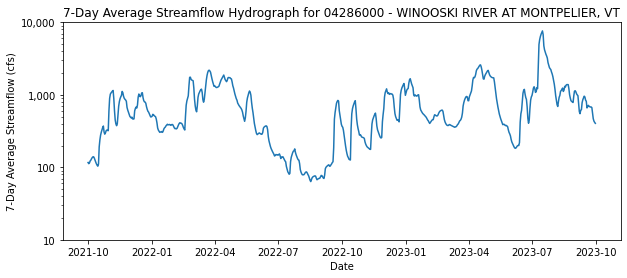

In [7]:
#| fig-cap: Sample HySwap hydrograph plot for 7-Day Average Streamflow
# calculate n-Day average streamflow
n = 7 
flow_data_nday = hyswap.utils.rolling_average(flow_data, '00060_Mean', n)
plot_start = "2021-10-01"
plot_end = "2023-09-30"
# make plot
fig, ax = plt.subplots(figsize=(10,4))
ax = hyswap.plot_hydrograph(flow_data_nday, 
                       data_col = "00060_Mean", 
                       start_date=plot_start,
                       end_date=plot_end,
                       title=f'{n}-Day Average Streamflow Hydrograph for {StaID} - {station_name}',
                       ylab=f"{n}-Day Average Streamflow (cfs)",
                       ax = ax)
plt.show()

## Look at long-term record of n-day streamflow as raster hydrograph

In [9]:
# try a raster hydrograph to see historical n-day flows
# format the data from the last 50 years of records (1972-2023)
df_formatted = hyswap.rasterhydrograph.format_data(flow_data, 
                                                   '00060_Mean', 
                                                   year_type="calendar", 
                                                   begin_year=1973, 
                                                   end_year=2023, 
                                                   data_type = "7-day")

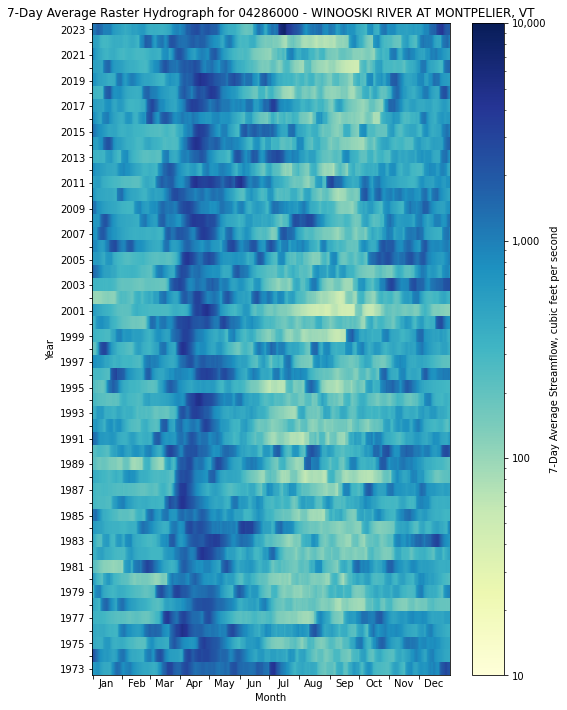

In [10]:
#| fig-cap: Sample raster hydrograph showing past 50 years of 7-day average streamflow

# make plot
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot()
ax = hyswap.plots.plot_raster_hydrograph(
    df_formatted, 
    ax=ax,
    title=f"7-Day Average Raster Hydrograph for {StaID} - {station_name}",
    cbarlab='7-Day Average Streamflow, cubic feet per second')
plt.show()

## Calculate streamflow percentiles for n-day flows
This example focuses on how the year 2023 compares to other years on record for this site. 
First, we will view how daily streamflow in 2023 compares to other years, and then compare 7-day and 28-day rolling means.

In [14]:
# get year/doy information
df_indexed = hyswap.utils.define_year_doy_columns(flow_data,
                                               year_type='water',
                                               clip_leap_day=True)
year_to_plot = 2023
# filter down to data from year to plot
df_year = df_indexed[df_indexed['index_year'] == year_to_plot].copy()
# calculate variable percentile thresholds (using only approved data)
percentiles_by_day = hyswap.percentiles.calculate_variable_percentile_thresholds_by_day(
    approved_flow_data, "00060_Mean")

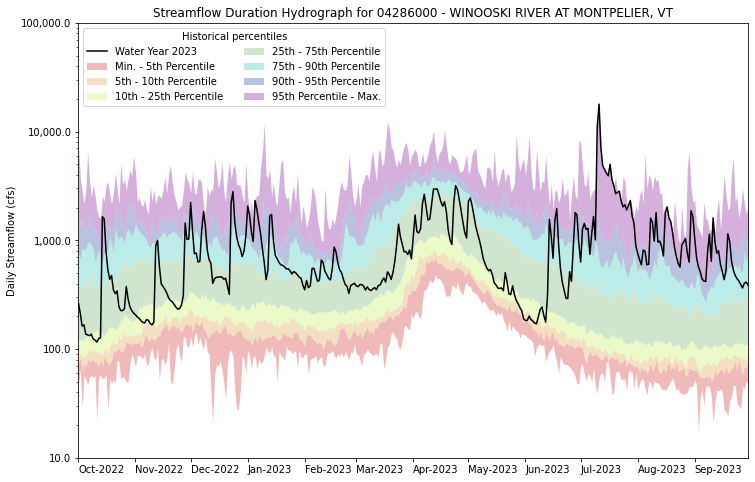

In [15]:
#| fig-cap: Example streamflow duration hydrograph with daily streamflow for the 2023 Water Year
# plot daily percentiles
fig, ax = plt.subplots(figsize=(12, 8))
ax = hyswap.plots.plot_duration_hydrograph(
    percentiles_by_day,
    df_year,
    "00060_Mean",
    ax=ax,
    data_label=f"Water Year {year_to_plot}",
    title=f"Streamflow Duration Hydrograph for {StaID} - {station_name}",
    xlab="",
    ylab="Daily Streamflow (cfs)"
)
plt.show()

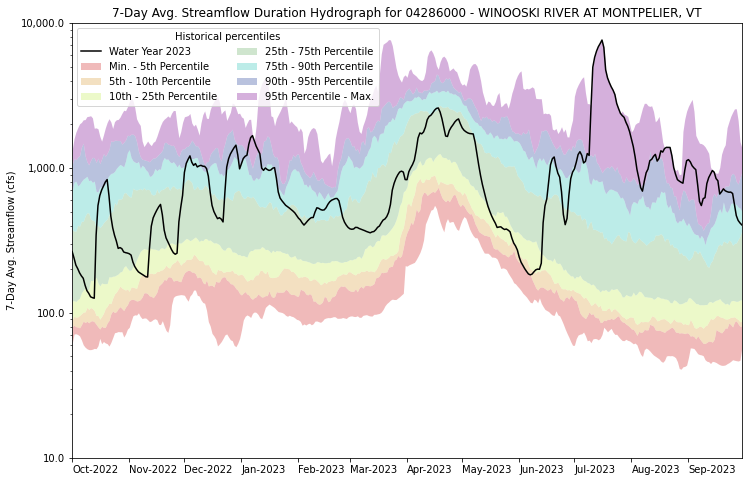

In [17]:
#| fig-cap: Example streamflow duration hydrograph with 7-day average streamflow for the 2023 Water Year
percentiles_by_nday = hyswap.percentiles.calculate_variable_percentile_thresholds_by_day(
    approved_flow_data, "00060_Mean", data_type='7-day')
n = 7
# plot 7-day avg percentiles
fig, ax = plt.subplots(figsize=(12, 8))
ax = hyswap.plots.plot_duration_hydrograph(
    percentiles_by_nday,
    hyswap.utils.rolling_average(df_year, "00060_Mean", n),
    "00060_Mean",
    ax=ax,
    data_label=f"Water Year {year_to_plot}",
    title=f"{n}-Day Avg. Streamflow Duration Hydrograph for {StaID} - {station_name}",
    xlab="",
    ylab=f"{n}-Day Avg. Streamflow (cfs)"
)
plt.show()

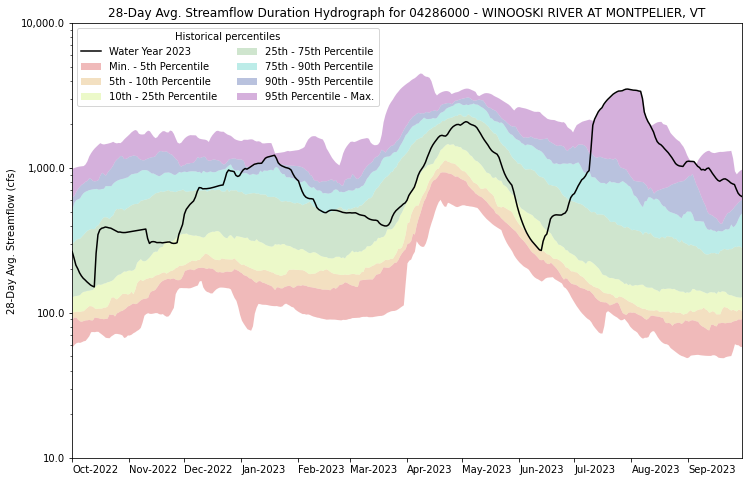

In [18]:
#| fig-cap: Example streamflow duration hydrograph with 28-day average streamflow for the 2023 Water Year
percentiles_by_nday = hyswap.percentiles.calculate_variable_percentile_thresholds_by_day(
    approved_flow_data, "00060_Mean", data_type='28-day')
n = 28
# plot 28-day average percentiles
fig, ax = plt.subplots(figsize=(12, 8))
ax = hyswap.plots.plot_duration_hydrograph(
    percentiles_by_nday,
    hyswap.utils.rolling_average(df_year, "00060_Mean", n),
    "00060_Mean",
    ax=ax,
    data_label=f"Water Year {year_to_plot}",
    title=f"{n}-Day Avg. Streamflow Duration Hydrograph for {StaID} - {station_name}",
    xlab="",
    ylab=f"{n}-Day Avg. Streamflow (cfs)"
)
plt.show()